In [ ]:
# Setup (PyTorch, paths, device, seeds)
import os, random, math, time
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import torch
import torch.nn as nn
import shutil
import tempfile
from PIL import Image
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import datasets, transforms ,models
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from contextlib import nullcontext
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

In [ ]:
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_all(42)

In [ ]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
# Use the returned path to set base_dir correctly
base_dir = os.path.join(path, "chest_xray")
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')

In [5]:
print("Train dir:", train_dir)
print("Val dir:", val_dir)
print("Test dir:", test_dir)

print("Train dir contents:", os.listdir(train_dir))
print("Val dir contents:", os.listdir(val_dir))
print("Test dir contents:", os.listdir(test_dir))

Train dir: /Users/daniel/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train
Val dir: /Users/daniel/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val
Test dir: /Users/daniel/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test
Train dir contents: ['.DS_Store', 'PNEUMONIA', 'NORMAL']
Val dir contents: ['.DS_Store', 'PNEUMONIA', 'NORMAL']
Test dir contents: ['.DS_Store', 'PNEUMONIA', 'NORMAL']


In [6]:
def plot_distribution_from_folder(base_dir, splits, class_names, title_prefix):
    for split in splits:
        counts = []
        for cls in class_names:
            folder = os.path.join(base_dir, split, cls)
            counts.append(len(os.listdir(folder)))
        plt.figure(figsize=(6,4))
        plt.bar(class_names, counts)
        plt.title(f"{title_prefix} {split} set class counts")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

Before split:
train/NORMAL: 1341
train/PNEUMONIA: 3875
val/NORMAL: 8
val/PNEUMONIA: 8


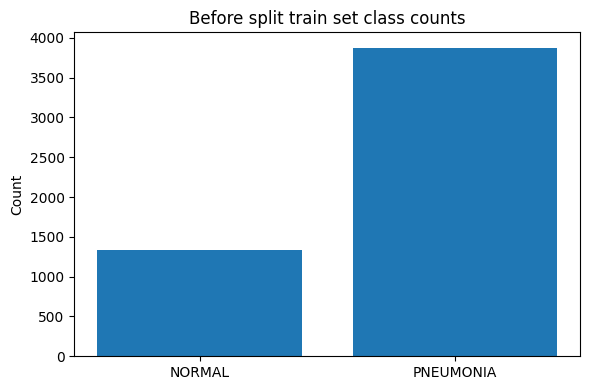

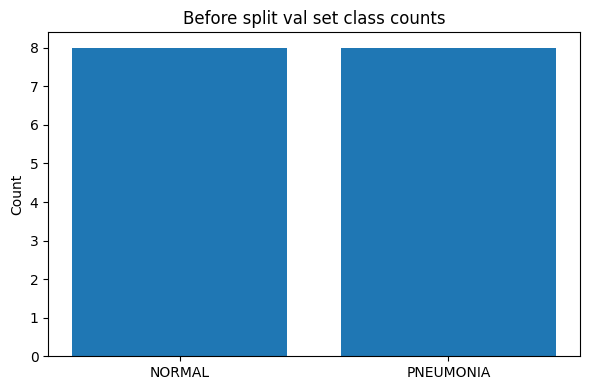

After split:
train/NORMAL: 1147
train/PNEUMONIA: 3300
val/NORMAL: 202
val/PNEUMONIA: 583


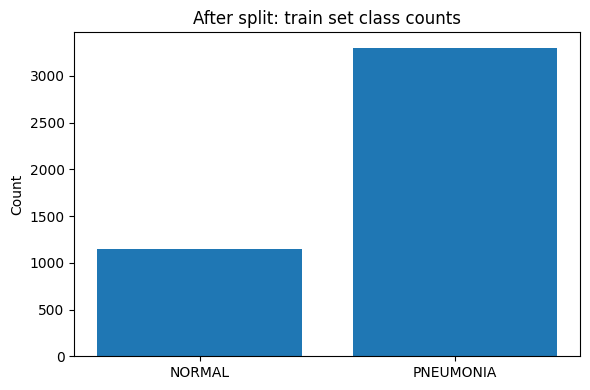

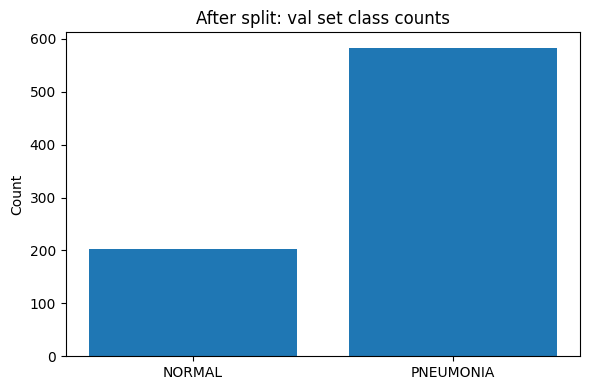

In [7]:
# Print image counts before shuffle/split
print('Before split:')
for split in ['train', 'val']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        folder = os.path.join(base_dir, split, cls)
        print(f"{split}/{cls}: {len(os.listdir(folder))}")

class_names = ['NORMAL', 'PNEUMONIA']
# Plot distribution before split
plot_distribution_from_folder(base_dir, ['train', 'val'], class_names, "Before split")

# Combine all images from train and val only (do not touch test)
all_data = []
for split in ['train', 'val']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        folder = os.path.join(base_dir, split, cls)
        for fname in os.listdir(folder):
            all_data.append((os.path.join(folder, fname), cls))

# Stratified split: 85% train, 15% val
paths, labels = zip(*all_data)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    paths, labels, test_size=0.15, stratify=labels, random_state=42)

def copy_files(file_paths, labels, dest_dir):
    for path, label in zip(file_paths, labels):
        dest = os.path.join(dest_dir, label)
        os.makedirs(dest, exist_ok=True)
        shutil.copy(path, dest)

# Set your new base_dir for split (must be writable, e.g., /kaggle/working or local path)
# Use /kaggle/working if running on Kaggle, or a local writable path otherwise

# Use a writable temp directory for the split
new_base = os.path.join(tempfile.gettempdir(), "chest_xray_split")
if os.path.exists(new_base):
    shutil.rmtree(new_base)
copy_files(train_paths, train_labels, os.path.join(new_base, 'train'))
copy_files(val_paths, val_labels, os.path.join(new_base, 'val'))

# Print image counts after shuffle/split
print('After split:')
for split in ['train', 'val']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        folder = os.path.join(new_base, split, cls)
        print(f"{split}/{cls}: {len(os.listdir(folder))}")

# Plot distribution after split
plot_distribution_from_folder(new_base, ['train', 'val'], class_names, "After split:")

# Update directory variables to point to the new split
train_dir = os.path.join(new_base, 'train')
val_dir   = os.path.join(new_base, 'val')
# test_dir remains unchanged

In [8]:
# Datasets, DataLoaders, class weights (for imbalance)
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_WORKERS = 4

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std =[0.229, 0.224, 0.225])

train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    normalize,
])

eval_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    normalize,
])

train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=eval_tfms)
test_ds  = datasets.ImageFolder(test_dir,  transform=eval_tfms)

print("Classes:", train_ds.classes, "=>", train_ds.class_to_idx)

Classes: ['NORMAL', 'PNEUMONIA'] => {'NORMAL': 0, 'PNEUMONIA': 1}


In [9]:
# CNN model as a class (__init__ + forward)
class PneumoCNN(nn.Module):
    def __init__(self, dropout_p=0.2):
        super(PneumoCNN, self).__init__()
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        m.fc = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(m.fc.in_features, 1)
        )
        self.net = m

    def forward(self, x):
        return self.net(x).squeeze(1)  # [B]

In [11]:
model = PneumoCNN()
model

PneumoCNN(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)
model = model.to(device)
EPOCHS = 15
patience = int(EPOCHS * 2/3)
lr = 1e-3

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

device:  cpu


In [13]:
# Compute class weights for BCEWithLogitsLoss (pos_weight = N_neg / N_pos for label=1 class)
# In ImageFolder, NORMAL -> 0, PNEUMONIA -> 1 (alphabetical)
train_targets = torch.tensor([y for _, y in train_ds.samples])
pos = (train_targets==1).sum().item()
neg = (train_targets==0).sum().item()
pos_weight = torch.tensor([neg / max(pos,1.0)], dtype=torch.float32)
print(f"Train counts -> NEG(NORMAL)={neg}, POS(PNEUMONIA)={pos}, pos_weight={pos_weight.item():.3f}")

Train counts -> NEG(NORMAL)=1147, POS(PNEUMONIA)=3300, pos_weight=0.348


In [15]:
# # Loss, Optimizer, LR scheduler
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))  # robust for class imbalance
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

In [16]:
def _run_epoch(model, loader, criterion, *, is_train, optimizer=None, acc_threshold=0.5, epochNumber=0, tag=""):
    """Core loop used by both train and eval."""
    model.train() if is_train else model.eval()
    ctx = nullcontext() if is_train else torch.inference_mode()

    epoch_loss, correct, n = 0.0, 0, 0
    all_probs, all_targets = [], []

    with ctx:
        for images, targets in tqdm(loader, desc=f"[{tag}] Epoch {epochNumber}/{EPOCHS}"):
            images  = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True).float()

            logits = model(images).squeeze(1)
            loss   = criterion(logits, targets)

            if is_train:
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()

            probs = torch.sigmoid(logits)
            preds = (probs >= acc_threshold).long()
            correct   += (preds == targets.long()).sum().item()
            n         += targets.size(0)
            epoch_loss += loss.item() * targets.size(0)

            all_probs.append(probs.detach().cpu())
            all_targets.append(targets.detach().cpu())

    avg_loss  = epoch_loss / n
    acc       = correct / n
    probs_np   = torch.cat(all_probs).numpy()
    targets_np = torch.cat(all_targets).numpy()
    try:
        auc = roc_auc_score(targets_np, probs_np)
    except Exception:
        auc = float("nan")
    return avg_loss, acc, auc, probs_np, targets_np

In [17]:
def train_one_epoch(model, loader, epochNumber, optimizer, criterion):
    return _run_epoch(model, loader, criterion,
                      is_train=True, optimizer=optimizer,
                      acc_threshold=0.5, epochNumber=epochNumber, tag="Train")

def eval_one_epoch(model, loader, epochNumber, criterion):
    return _run_epoch(model, loader, criterion,
                      is_train=False, optimizer=None,
                      acc_threshold=0.5, epochNumber=epochNumber, tag="Eval")

In [18]:
def fit(model, train_loader, val_loader, criterion, optimizer, scheduler=None, epochs=15, patience=10):
    best_val_auc, no_improve = -np.inf, 0
    ckpt_path = "best_cnn_pneumonia.pt"
    history = {"train_loss":[], "train_acc":[], "train_auc":[],
               "val_loss":[], "val_acc":[], "val_auc":[]}

    start = time.time()
    for epoch in range(1, epochs+1):
        tr_loss, tr_acc, tr_auc, _, _ = train_one_epoch(model, train_loader, epoch, optimizer, criterion)
        val_loss, val_acc, val_auc, _, _ = eval_one_epoch(model, val_loader, epoch, criterion)

        if scheduler is not None:
            scheduler.step(val_auc)

        history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc); history["train_auc"].append(tr_auc)
        history["val_loss"].append(val_loss);   history["val_acc"].append(val_acc);   history["val_auc"].append(val_auc)

        print(f"Epoch {epoch:02d}/{epochs} | "
              f"Train Loss {tr_loss:.4f} Accuracy {tr_acc:.4f} AUC {tr_auc:.4f} | "
              f"Val Loss {val_loss:.4f} Accuracy {val_acc:.4f} AUC {val_auc:.4f}")

        # Early stopping & checkpoint
        if val_auc > best_val_auc:
            best_val_auc, no_improve = val_auc, 0
            torch.save({"model_state": model.state_dict(),
                        "optimizer_state": optimizer.state_dict(),
                        "epoch": epoch}, ckpt_path)
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping at epoch {epoch}. Best val AUC={best_val_auc:.4f}")
                break

    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    print(f"Training finished in {(time.time()-start)/60:.1f} min. Best val AUC: {best_val_auc:.4f}")
    return history, best_val_auc

In [19]:
def plot_curves(h):
    fig, axs = plt.subplots(1,3, figsize=(16,4))
    axs[0].plot(h["train_loss"], label="train"); axs[0].plot(h["val_loss"], label="val")
    axs[0].set_title("Loss"); axs[0].legend()
    axs[1].plot(h["train_acc"], label="train"); axs[1].plot(h["val_acc"], label="val")
    axs[1].set_title("Accuracy"); axs[1].legend()
    axs[2].plot(h["train_auc"], label="train"); axs[2].plot(h["val_auc"], label="val")
    axs[2].set_title("ROC-AUC"); axs[2].legend()
    plt.show()

In [20]:
history, best_val_auc = fit(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=EPOCHS, patience=patience)

plot_curves(history)

[Train] Epoch 1/15:   0%|          | 0/70 [00:00<?, ?it/s]/opt/anaconda3/envs/ml/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x152a2be20>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/ml/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/opt/anaconda3/envs/ml/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/anaconda3/envs/ml/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/ml/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
def pick_threshold_from_val(y_true, y_prob):
    prec, rec, thr = precision_recall_curve(y_true, y_prob)  # thr len = len(prec)-1
    f1 = 2*prec[:-1]*rec[:-1]/(prec[:-1]+rec[:-1]+1e-12)
    return float(thr[np.argmax(f1)])

In [ ]:
_, _, va_auc, va_probs, va_targets = eval_one_epoch(model, val_loader, epochNumber=0, criterion=criterion)
best_thr = pick_threshold_from_val(va_targets, va_probs)
print("Chosen threshold:", best_thr)

In [ ]:
def evaluate_with_threshold(model, loader, criterion, threshold):
    loss, acc05, auc, probs, targets = eval_one_epoch(model, loader, epochNumber=0, criterion=criterion)
    preds = (probs >= threshold).astype(int)
    acc_thr = (preds == targets).mean()
    cm = confusion_matrix(targets, preds)
    tn, fp, fn, tp = cm.ravel()
    spec = tn / (tn + fp + 1e-12)
    sens = tp / (tp + fn + 1e-12)
    bal_acc = (spec + sens) / 2
    pr_auc = average_precision_score(targets, probs)
    return {"loss":loss, "acc@thr":acc_thr, "auc":auc,
            "specificity":spec, "sensitivity":sens,
            "balanced_acc":bal_acc, "pr_auc":pr_auc,
            "cm":cm, "probs":probs, "targets":targets}

In [ ]:
test_metrics = evaluate_with_threshold(model, test_loader, criterion, threshold=best_thr)
print(f"TEST — loss: {test_metrics['loss']:.4f} | acc@thr: {test_metrics['acc@thr']:.4f} | auc: {test_metrics['auc']:.4f}")
print(f"Specificity: {test_metrics['specificity']:.4f} | Sensitivity: {test_metrics['sensitivity']:.4f} | "
      f"Balanced Acc: {test_metrics['balanced_acc']:.4f} | PR-AUC: {test_metrics['pr_auc']:.4f}")
print("Confusion Matrix:\n", test_metrics['cm'])

print("\nClassification Report:\n",
      classification_report(test_metrics['targets'],
                            (test_metrics['probs']>=best_thr).astype(int),
                            target_names=test_ds.classes, digits=4))

# ROC curve (test)
fpr, tpr, _ = roc_curve(test_metrics['targets'], test_metrics['probs'])
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, lw=2); plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve (Test)')
plt.grid(True); plt.show()

In [ ]:
def predict_image(path, model, tfms=eval_tfms, threshold=0.5):
    model.eval()
    img = Image.open(path).convert("RGB")
    x = tfms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logit = model(x)
        prob = torch.sigmoid(logit).item()
    pred = int(prob >= threshold)
    return prob, pred  # P(pneumonia), predicted label